pip install pyshp: necessary command to get pyshp library into jupyter

In [2]:
import shapefile # import shapefile library
fname = 'sinuosity_shapefiles/sin_CM7.shp' # define channel to be analysed

each shapefile contains polylines of the channel in question for each year that it was analysed. CM1-3 and 6 are analysed for 2000 - 2017, CM5 for 2012 - 2017 and CM7 for 2009 - 2017

In [3]:
reader = shapefile.Reader(fname) # reads in shapefile identified above
shps = reader.shapes() # reads all polylines within shapefile
#/sinuosity_shapefiles/sin_CM6.shp
print([shp.shapeTypeName for shp in shps]) # shows number of polylines in shapefile

['POLYLINE', 'POLYLINE', 'POLYLINE', 'POLYLINE']


In [28]:
shaperecords = reader.shapeRecords()
for shaperecord in shaperecords:
    print(list(shaperecord.record)) # unsorted list of attributes for polylines

[2017, 2017, None]
[2012, 2012, None]
[2014, 2014, None]
[2009, 2009, None]


In [5]:
# sort polylines by year

def y(shaperecord):
    return shaperecord.record[0]

shaperecords.sort(key=y)

In [6]:
for shaperecord in shaperecords:
    print(list(shaperecord.record), y(shaperecord))

[2009, 2009, None] 2009
[2012, 2012, None] 2012
[2014, 2014, None] 2014
[2017, 2017, None] 2017


plot a channel profile from a given year and convert from lat-lon to degrees

In [7]:
%matplotlib inline 
from matplotlib import pyplot as plt

Text(0, 0.5, 'lat, dec deg')

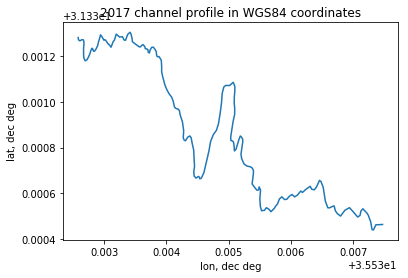

In [8]:
shaperecord = shaperecords[-1]
pshp = shaperecord.shape.points
year = shaperecord.record[0]
lngs, lats = list(zip(*pshp)) # reorder the points into lat and lon columns using zip
plt.plot(lngs, lats) # plot with lat correct
plt.title('%d channel profile in WGS84 coordinates' % year)
plt.xlabel('lon, dec deg')
plt.ylabel('lat, dec deg')

In [9]:
import math

# bodge converting from lat-lon to metres by using earth as a sphere
def convertlatlngtoxy(lats, lngs):
    lng0, lat0 = lngs[0], lats[0]
    earthrad = 6378137
    nyfac = 2*math.pi*earthrad/360
    exfac = nyfac*math.cos(math.radians(lat0))
    xs = [(lng - lng0)*exfac  for lng in lngs]  
    ys = [(lat - lat0)*nyfac  for lat in lats]  
    return xs, ys

Text(0, 0.5, 'y position [m]')

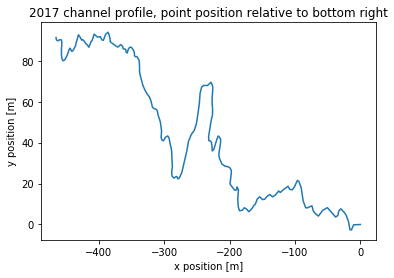

In [10]:
xs, ys = convertlatlngtoxy(lats, lngs)
plt.plot(xs, ys)
plt.title('%d channel profile, point position relative to bottom right' % year)
plt.xlabel('x position [m]')
plt.ylabel('y position [m]')

We start the pandas work here.

pandas is a tool which allows for easy data manipulation and analysis. it has some cool shortcuts and tricks built in.


In [11]:
import pandas as pd

# select the polyline from the shapefile that you wish to investigate ie the year

shaperecord = shaperecords[-1]
pshp = shaperecord.shape.points
year = shaperecord.record[0]
lngs, lats = list(zip(*pshp))
df = pd.DataFrame({"lat":lats, "lng":lngs}) # dataframe equivalent of matrix/array in matlab
lat0, lng0 = df.lat.iloc[0], df.lng.iloc[0]


In [12]:
# This should properly be done with Proj4 or something
# but we bodge it using earth as a sphere
earthrad = 6378137
nyfac = 2*math.pi*earthrad/360
exfac = nyfac*math.cos(math.radians(lat0))
df["x"] = (df.lng - lng0)*exfac # x positions of channel in dataframe
df["y"] = (df.lat - lat0)*nyfac # y positions of channel in dataframe

make a tapered moving window which has a certain radius (width) to filter and smooth the channel profile, effectively simulating the 'valley slope' profile. The area beneath the curve must total 1, following gaussian distribution

first, a demo version to show the theory

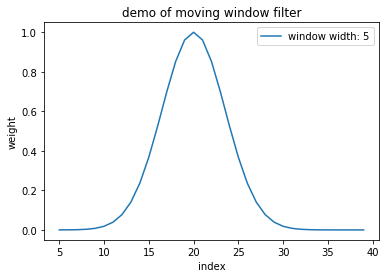

In [13]:
import numpy as np
centreweightindex = 20 # arbitrary pick so that we can see what is happening on the graph
centreweightrad = 5 # this is what controls the smoothedness of the graph
def makeweightseries(centreweightindex, centreweightrad):
    indexcolumn = df.index.to_series()
    w = np.exp(-((indexcolumn - centreweightindex)/centreweightrad)**2)
    return w
w = makeweightseries(centreweightindex, centreweightrad)
plt.plot(w.iloc[5:40], label='window width: 5')
plt.title('demo of moving window filter')
plt.xlabel('index')
plt.ylabel('weight')
plt.legend(loc = 'upper right')

apply moving window to stream channel path to calculate 'line of least resistance ie valley slope

Really we should do this only for the final dataet in the time series (ie the position of the channel in 2017) and then use this 'valley slope' for all of the years of the channels

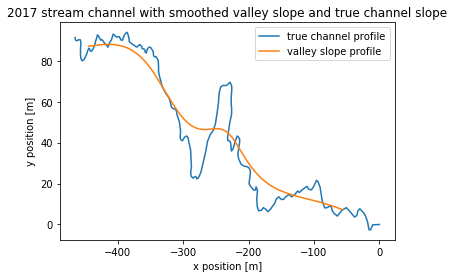

In [14]:
wxs, wys = [ ], [ ]
centreweightrad = 25 # width of smoothing moving window in metres
for centreweightindex in range(len(df.x)):
    w = makeweightseries(centreweightindex, centreweightrad)
    wx = sum(w*df.x)/sum(w)
    wy = sum(w*df.y)/sum(w)
    wxs.append(wx)
    wys.append(wy)
    
plt.plot(df.x, df.y, label='true channel profile')
plt.plot(wxs, wys, label='valley slope profile')
plt.title('%d stream channel with smoothed valley slope and true channel slope' % year)
plt.xlabel('x position [m]')
plt.ylabel('y position [m]')
plt.legend()
# plt.savefig('%d_true-vs-valley.png' %year, bbox_inches='tight')

In [15]:
# stream vector
sx = df.x.iloc[-1] - df.x.iloc[0]
sy = df.y.iloc[-1] - df.y.iloc[0]
slen = math.sqrt(sx**2 + sy**2)
sx, sy = sx/slen, sy/slen
sx, sy  # unit vector

(-0.981253838082642, 0.19271975832302307)

In [16]:
df["vx"] = (df.x.shift(-1) - df.x)
df.vx.iloc[-1] = 0  # force the final nan to be zero
df["vy"] = (df.y.shift(-1) - df.y)
df.vy.iloc[-1] = 0
df["segleng"] = np.sqrt(df.vx**2 + df.vy**2)


In [17]:
weightedstreamlength = sum(df.segleng*w)/sum(w)
weighteddirectlength = sum(df.vx*sx*w+df.vy*sy*w)/sum(w)
weightedsinuosity = weightedstreamlength/weighteddirectlength
weightedsinuosity # average sinuosity of the entire channel


1.3909270305917039

In [18]:
wxs, wys = [ ], [ ]
wsin = [ ]
centreweightrad = 25
for centreweightindex in range(len(df.x)):
    w = makeweightseries(centreweightindex, centreweightrad)
    
    wx = sum(w*df.x)/sum(w)
    wy = sum(w*df.y)/sum(w)
    
    weightedstreamlength = sum(df.segleng*w)/sum(w)
    weighteddirectlength = sum(df.vx*sx*w+df.vy*sy*w)/sum(w)
    weightedsinuosity = weightedstreamlength/weighteddirectlength
    wsin.append(weightedsinuosity)
    wxs.append(wx)
    wys.append(wy)
    
wxs = np.array(wxs)
wys = np.array(wys)
awsin = np.array(wsin)


In [19]:
a = [1,2,3,4,54]
np.array(a) + 1000

array([1001, 1002, 1003, 1004, 1054])

Text(0, 0.5, 'sinuosity')

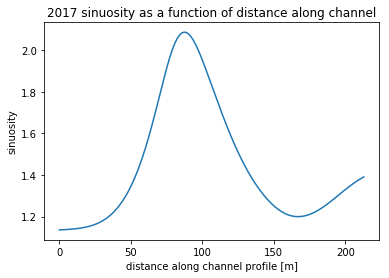

In [20]:
# plot sinuosity as a function of distance along channel
plt.plot(awsin)
plt.title('%d sinuosity as a function of distance along channel' % year)
plt.xlabel('distance along channel profile [m]')
plt.ylabel('sinuosity')
# plt.savefig('%d_sin_dist.png' %year, bbox_inches='tight')

In [21]:
awsin.min(), awsin.max()

(1.13574699766037, 2.0874309639413897)

plot all the necessary figures together as one subplot and save

TypeError: 'AxesSubplot' object is not iterable

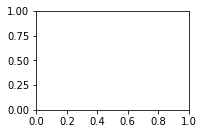

In [26]:


# use https://matplotlib.org/gallery/lines_bars_and_markers/multicolored_line.html
from matplotlib.collections import LineCollection
points = np.array([wxs, wys]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
awsin = np.array(wsin)
norm = plt.Normalize(awsin.min(), awsin.max())
lc = LineCollection(segments, cmap='YlOrBr', norm=norm)
lc.set_array(awsin)
lc.set_linewidth(5)
#cm = plt.get_cmap("winter")
fig, axs = plt.subplot(2,2,4)
ax = axs

line = ax.add_collection(lc)
#segments
#plt.show()
#ax.gca()

#ax.set_xlim(min(wxs), max(wxs))
#ax.set_ylim(min(wys), max(wys))
fig.colorbar(line, ax=axs, label="sinuosity")
plt.plot(df.x, df.y, color="blue")
plt.title('%d sinuosity evolution along channel profile' %year)
plt.xlabel('x position [m]')
plt.ylabel('y position [m]')
plt.savefig('%d_sin-channelprof.png' %year, bbox_inches='tight')
plt.show()

Text(0, 0.5, 'sinuosity')

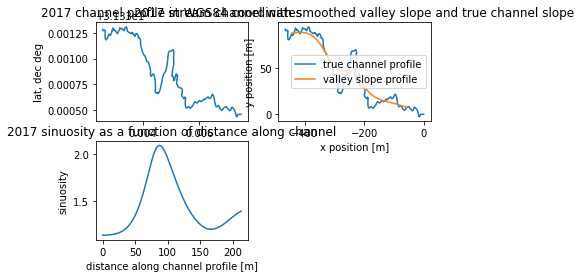

In [24]:
plt.subplot(221)
plt.plot(lngs, lats) # plot with lat correct
plt.title('%d channel profile in WGS84 coordinates' % year)
plt.xlabel('lon, dec deg')
plt.ylabel('lat, dec deg')

plt.subplot(222)
plt.plot(df.x, df.y, label='true channel profile')
plt.plot(wxs, wys, label='valley slope profile')
plt.title('%d stream channel with smoothed valley slope and true channel slope' % year)
plt.xlabel('x position [m]')
plt.ylabel('y position [m]')
plt.legend()

plt.subplot(223)
plt.plot(awsin)
plt.title('%d sinuosity as a function of distance along channel' % year)
plt.xlabel('distance along channel profile [m]')
plt.ylabel('sinuosity')
